In [20]:
# from huggingface_hub import login
# login(token="")
import pandas as pd

In [21]:
# import pandas as pd
# import os

# # Path to your dataset folder
# data_path = "../dataset/"

# # List all CSV files in that folder
# csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]

# # Read and combine all CSV files
# dfs = []
# for file in csv_files:
#     file_path = os.path.join(data_path, file)
#     print(f"Loading: {file}")
#     df = pd.read_csv(file_path)
#     dfs.append(df)

# # Concatenate all into one DataFrame
# merged_df = pd.concat(dfs, ignore_index=True)

# # Drop duplicates if any
# merged_df.drop_duplicates(inplace=True)

# # Optional: clean text (remove line breaks, extra spaces)
# merged_df["Question"] = merged_df["Question"].str.replace(r'\s+', ' ', regex=True).str.strip()
# merged_df["Answer"] = merged_df["Answer"].str.replace(r'\s+', ' ', regex=True).str.strip()

# # Check the merged result
# print("Merged dataset shape:", merged_df.shape)
# print(merged_df.head(10))

# # Save to a single CSV file
# merged_df.to_csv("../merged_health_dataset.csv", index=False)
# print("✅ Merged dataset saved as '../merged_health_dataset.csv'")



In [22]:
df = pd.read_csv("../dataset/merged_health_dataset.csv")

# Health Q&A Chatbot — Data engineering, training & evaluation
**Author:** Chriss  
**Purpose:** Clean and preprocess merged health Q&A dataset, prepare both retrieval and generative training data, train models, tune hyperparameters, evaluate quantitatively and qualitatively, and save models for deployment.  
**Data:** `../dataset/merged_health_dataset.csv` (columns: `Question`, `Answer`, `topic`, `split`)  
**Notes:** This notebook follows best practices: reproducible seeds, logging, minimal leaking between splits, and explicit handling of out-of-domain rejection.


In [23]:
# Code cell: imports, constants, seed
import os
import re
import json
from pathlib import Path
from collections import Counter
import random
import logging
import math

import pandas as pd
import numpy as np

# NLP & ML libs
import nltk
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from datasets import Dataset, DatasetDict
import evaluate  # updated for metrics

# Transformers & sentence embeddings
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from sentence_transformers import SentenceTransformer, util

# Faiss for vector index
import faiss

# Set logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [24]:
# Run if missing packages (uncomment to install)
# !pip install -q nltk transformers datasets sentence-transformers faiss-cpu optuna accelerate rouge_score sacrebleu

# NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/lscblack/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lscblack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Load merged dataset
DATA_PATH = "../dataset/merged_health_dataset.csv"
df = pd.read_csv(DATA_PATH)

# Quick overview
print("Rows:", len(df))
print(df.columns.tolist())
display(df.head(6))
display(df['topic'].value_counts().head(20))
display(df['split'].value_counts())


Rows: 16371
['Question', 'Answer', 'topic', 'split']


,Question,Answer,topic,split
0,What is (are) Non-Small Cell Lung Cancer ?,Key Points - Non-small cell lung cancer is a d...,cancer,train
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer,train
2,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer,test
3,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer,train
4,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer,train
5,What are the stages of Non-Small Cell Lung Can...,Key Points - After lung cancer has been diagno...,cancer,train


topic
growth_hormone_receptor          5430
Genetic_and_Rare_Diseases        5388
Diabetes_Digestive_Kidney        1157
Neurological_Disorders_Stroke    1088
Other                             981
SeniorHealth                      769
cancer                            729
Heart_Lung_Blood                  559
Disease_Control_Prevention        270
Name: count, dtype: int64

split
train    13089
test      3282
Name: count, dtype: int64

**EDA checklist**
- Inspect missing values for Question/Answer/topic
- Check duplicate Q/A pairs and near-duplicates
- Distribution of topics (class imbalance)
- Very short/long answers or questions (outliers)
- Broken HTML tags or "Key Points\n" artifacts
- Language detection / non-English entries


In [26]:
# Drop rows missing Q/A
df = df.dropna(subset=['Question', 'Answer']).reset_index(drop=True)

# Normalize column names
df.columns = [c.strip() for c in df.columns]
# Lowercase topic
df['topic'] = df['topic'].astype(str).str.lower().str.strip()

# Drop exact duplicates
before = len(df)
df = df.drop_duplicates(subset=['Question','Answer'])
logger.info(f"Dropped {before - len(df)} exact duplicate rows")

# Remove rows with extremely short Q or A
df = df[(df['Question'].str.len() > 10) & (df['Answer'].str.len() > 20)].reset_index(drop=True)
logger.info("After dropping very short Q/A: %d rows", len(df))

df.head()


INFO:__main__:Dropped 13 exact duplicate rows
INFO:__main__:After dropping very short Q/A: 16357 rows


,Question,Answer,topic,split
0,What is (are) Non-Small Cell Lung Cancer ?,Key Points - Non-small cell lung cancer is a d...,cancer,train
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer,train
2,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer,test
3,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer,train
4,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer,train


In [27]:
# Cleaning utilities
import html
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    t = html.unescape(text)              # unescape HTML entities
    t = re.sub(r'\n+', ' ', t)           # remove newlines
    t = re.sub(r'\[.*?\]', ' ', t)       # remove bracketed text
    t = re.sub(r'Key Points[:\s-]*', '', t, flags=re.I)  # remove "Key Points"
    t = re.sub(r'\s+', ' ', t)           # collapse whitespace
    t = t.strip()
    return t

df['Question_clean'] = df['Question'].apply(clean_text)
df['Answer_clean'] = df['Answer'].apply(clean_text)

# optional: lowercase Q for retrieval
df['Question_norm'] = df['Question_clean'].str.lower()
df['Answer_norm'] = df['Answer_clean'].str.strip()

df[['Question','Question_clean','Answer_clean']].head(6)


,Question,Question_clean,Answer_clean
0,What is (are) Non-Small Cell Lung Cancer ?,What is (are) Non-Small Cell Lung Cancer ?,Non-small cell lung cancer is a disease in whi...
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...
2,What are the symptoms of Non-Small Cell Lung C...,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...
3,How to diagnose Non-Small Cell Lung Cancer ?,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...
4,What is the outlook for Non-Small Cell Lung Ca...,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...
5,What are the stages of Non-Small Cell Lung Can...,What are the stages of Non-Small Cell Lung Can...,"After lung cancer has been diagnosed, tests ar..."


In [28]:
# Optional: detect language and keep English entries (fasttext/langdetect)
# pip install langdetect
from langdetect import detect, DetectorFactory
DetectorFactory.seed = SEED

def is_english(s):
    try:
        return detect(s) == 'en'
    except:
        return False

# Apply sample check (do not run for huge datasets without batching)
df['is_english'] = df['Question_clean'].apply(is_english)
print("English fraction:", df['is_english'].mean())
# If many non-English rows for your target locale, translate or keep them.
df = df[df['is_english']].reset_index(drop=True)


English fraction: 0.971510668215443


In [29]:
# Normalize topics (strip punctuation, unify synonyms)
df['topic'] = df['topic'].str.replace(r'[^a-z0-9_ ]','',regex=True).str.strip()

# Show top topics
display(df['topic'].value_counts().head(40))

# Optionally bin small topics into 'other' for stratified splitting
topic_counts = df['topic'].value_counts()
rare_threshold = 50  # tune
rare_topics = topic_counts[topic_counts < rare_threshold].index.tolist()
df['topic_group'] = df['topic'].apply(lambda x: 'other' if x in rare_topics else x)

display(df['topic_group'].value_counts().head(40))


topic
growth_hormone_receptor          5303
genetic_and_rare_diseases        5153
diabetes_digestive_kidney        1126
neurological_disorders_stroke    1082
other                             972
seniorhealth                      756
cancer                            712
heart_lung_blood                  529
disease_control_prevention        258
Name: count, dtype: int64

topic_group
growth_hormone_receptor          5303
genetic_and_rare_diseases        5153
diabetes_digestive_kidney        1126
neurological_disorders_stroke    1082
other                             972
seniorhealth                      756
cancer                            712
heart_lung_blood                  529
disease_control_prevention        258
Name: count, dtype: int64

In [30]:
OUT_DIR = Path("../models/processed-v6")
OUT_DIR.mkdir(parents=True, exist_ok=True)
clean_path = OUT_DIR / "health_qa_cleaned.csv"
df.to_csv(clean_path, index=False)
logger.info(f"Saved cleaned CSV to {clean_path}")


INFO:__main__:Saved cleaned CSV to ../models/processed-v6/health_qa_cleaned.csv


We will prepare two pipelines:
1. **Retrieval-based Q&A**: Build an embedding index (sentence-transformers + FAISS) and return the top-k passages; then a reranker or small seq2seq to reformat answers if needed.
2. **Generative Q&A (seq2seq)**: Fine-tune a small sequence-to-sequence model (T5/Flan-T5/MT5 or BART) on question→answer pairs for direct generation.

Both pipelines complement one another: retrieval has high factuality; generative handles conversational paraphrase and short answers.


In [31]:
# Your existing split code
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['topic_group'], random_state=SEED)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['topic_group'], random_state=SEED)

print("Before oversampling:")
print("Train:", len(train_df), "Valid:", len(valid_df), "Test:", len(test_df))

# OVERSAMPLING - Add this right after your split
from sklearn.utils import resample

print("\nApplying oversampling to training data...")
topic_counts = train_df['topic_group'].value_counts()
target_size = int(topic_counts.median())  # Balance to median class size

print(f"Oversampling target: {target_size} samples per class")

oversampled_dfs = []
for topic in train_df['topic_group'].unique():
    topic_df = train_df[train_df['topic_group'] == topic]
    current_size = len(topic_df)
    
    if current_size < target_size:
        # Oversample minority class
        oversampled_df = resample(topic_df,
                                replace=True,
                                n_samples=target_size,
                                random_state=SEED)
        oversampled_dfs.append(oversampled_df)
        print(f"  {topic}: {current_size} → {target_size} (oversampled)")
    else:
        # Keep majority class as is
        oversampled_dfs.append(topic_df)
        print(f"  {topic}: {current_size} (unchanged)")

# Combine and shuffle
balanced_train_df = pd.concat(oversampled_dfs, ignore_index=True)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"\nAfter oversampling:")
print("Train:", len(balanced_train_df), "Valid:", len(valid_df), "Test:", len(test_df))

# Save balanced splits
balanced_train_df.to_csv(OUT_DIR / "train.csv", index=False)
valid_df.to_csv(OUT_DIR / "valid.csv", index=False)
test_df.to_csv(OUT_DIR / "test.csv", index=False)

print("Balanced datasets saved!")

Before oversampling:
Train: 12712 Valid: 1589 Test: 1590

Applying oversampling to training data...
Oversampling target: 778 samples per class
  seniorhealth: 605 → 778 (oversampled)
  genetic_and_rare_diseases: 4122 (unchanged)
  diabetes_digestive_kidney: 901 (unchanged)
  growth_hormone_receptor: 4242 (unchanged)
  heart_lung_blood: 423 → 778 (oversampled)
  neurological_disorders_stroke: 865 (unchanged)
  cancer: 570 → 778 (oversampled)
  other: 778 (unchanged)
  disease_control_prevention: 206 → 778 (oversampled)

After oversampling:
Train: 14020 Valid: 1589 Test: 1590
Balanced datasets saved!


**Retrieval preparation**
- Corpus: use Answer text as passages, optionally chunk long answers into passages (e.g., 200-300 tokens).
- Encode passages with `sentence-transformers` (e.g., `all-MiniLM-L6-v2` or `multi-qa-MiniLM-L6` for Q->P retrieval).
- Build FAISS index (IVF or HNSW depending on size).


In [32]:
from sentence_transformers import SentenceTransformer
model_name = "all-MiniLM-L6-v2"  # small, fast, good for production
embedder = SentenceTransformer(model_name)

# Corpus: one passage per Answer (or chunking if very long)
corpus_df = train_df[['Answer_clean']].drop_duplicates().reset_index(drop=True)
corpus_texts = corpus_df['Answer_clean'].tolist()
print("Corpus size:", len(corpus_texts))

# Encode in batches
corpus_embeddings = embedder.encode(corpus_texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# Build FAISS index (cosine similarity)
d = corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # inner product = cosine if embeddings normalized
faiss.normalize_L2(corpus_embeddings)
index.add(corpus_embeddings)
print("FAISS index size:", index.ntotal)

# Save index and corpus texts
faiss.write_index(index, str(OUT_DIR / "faiss_index.ivf"))
np.save(OUT_DIR / "corpus_texts.npy", np.array(corpus_texts))
print("Saved FAISS index and corpus.")


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Corpus size: 12313

















































































































































Batches: 100%|██████████| 193/193 [00:21<00:00,  8.78it/s]


FAISS index size: 12313
Saved FAISS index and corpus.


In [33]:
def retrieve_answers(query, k=5):
    q_emb = embedder.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, k)
    results = []
    for idx, score in zip(I[0], D[0]):
        results.append({'answer': corpus_texts[idx], 'score': float(score)})
    return results

# Example
print(retrieve_answers("What are early symptoms of lung cancer?", k=3))



Batches: 100%|██████████| 1/1 [00:00<00:00, 220.12it/s]

[{'answer': "The possible signs of lung cancer are: - a cough that doesn't go away and gets worse over time - constant chest pain - coughing up blood - shortness of breath, wheezing, or hoarseness - repeated problems with pneumonia or bronchitis - swelling of the neck and face - loss of appetite or weight loss - fatigue. a cough that doesn't go away and gets worse over time constant chest pain coughing up blood shortness of breath, wheezing, or hoarseness repeated problems with pneumonia or bronchitis swelling of the neck and face loss of appetite or weight loss fatigue.", 'score': 0.7947052717208862}, {'answer': "Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Sometimes lung cancer does not cause any signs or symptoms. It may be found during a chest x-ray done for another condition. Signs and symptoms may be caused by lung cancer or by other conditions. Check with your doctor if you have any of the following: - Chest discomfort or pain

**Generative training format**
- Use a compact prompt prefix to contextualize: `"question: {Question_clean}  context: {topic}"` → target `{Answer_clean}`
- Tokenizer & model: `t5-small` or `google/mt5-small` for multilingual. For constrained resources use `t5-small` and `transformers` Trainer.
- Use max input length 256, max target length 256 (adjust by distribution).


In [34]:
from datasets import Dataset, DatasetDict

# Build datasets
hf_train = Dataset.from_pandas(train_df[['Question_clean','Answer_clean','topic_group']])
hf_valid = Dataset.from_pandas(valid_df[['Question_clean','Answer_clean','topic_group']])
hf_test = Dataset.from_pandas(test_df[['Question_clean','Answer_clean','topic_group']])

ds = DatasetDict({"train": hf_train, "validation": hf_valid, "test": hf_test})

# Tokenizer & model prep
# MODEL_NAME = "t5-small"   # pick t5-small or small seq2seq
MODEL_NAME = "google/flan-t5-small"   # pick t5-small or small seq2seq
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Preprocessing fn
max_input_length = 256
max_target_length = 256

# Cell: Completely fixed preprocessing function
def preprocess_function(examples):
    # Build source text
    inputs = [f"question: {q} topic: {t}" for q, t in zip(examples['Question_clean'], examples['topic_group'])]
    
    # Encode inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        padding=False,
        truncation=True,
    )

    # Encode targets (answers)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            [a if a is not None else "" for a in examples["Answer_clean"]],
            max_length=max_target_length,
            padding=False,
            truncation=True,
        )

    # Only add non-empty labels
    model_inputs["labels"] = [
        l if len(l) > 0 else [tokenizer.pad_token_id] for l in labels["input_ids"]
    ]

    return model_inputs

# Re-process the dataset with CORRECT preprocessing
print("Re-processing dataset with correct preprocessing...")
tokenized_ds = ds.map(preprocess_function, batched=True,   num_proc=14, remove_columns=ds["train"].column_names)

print("Sample processed example:")
print("Input IDs length:", len(tokenized_ds["train"][0]["input_ids"]))
print("Labels length:", len(tokenized_ds["train"][0]["labels"]))
print("First few input tokens:", tokenized_ds["train"][0]["input_ids"][:10])
print("First few label tokens:", tokenized_ds["train"][0]["labels"][:10])

Re-processing dataset with correct preprocessing...



/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenize

Sample processed example:
Input IDs length: 18
Labels length: 86
First few input tokens: [822, 10, 363, 19, 41, 355, 61, 25904, 31, 7]
First few label tokens: [37, 25904, 7, 14326, 3318, 3920, 277, 31474, 3426, 6]


In [35]:
# Install if not already
# !pip install optuna plotly

import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt


In [36]:

# Cell: Update training arguments with better hyperparameters
from transformers import EarlyStoppingCallback

# Add early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=6,
    early_stopping_threshold=0.1
)

training_args = Seq2SeqTrainingArguments(
    output_dir=str(OUT_DIR / "t5_health"),
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    predict_with_generate=True,
    logging_steps=200,
    eval_steps=500,            # evaluation interval
    save_steps=1000,           # save interval
    save_total_limit=3,
    num_train_epochs=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    seed=SEED,
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    eval_strategy="steps",     # ensure evaluation happens at each interval
)


print(f"Training arguments configured for {MODEL_NAME}")



Training arguments configured for google/flan-t5-small


In [37]:
import evaluate
from collections import Counter
import numpy as np

bleu = evaluate.load("sacrebleu")
rouge = evaluate.load("rouge")
# Cell: Fixed compute_metrics function
def compute_metrics_for_generation(pred):
    # Handle tuple predictions
    preds = pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]

    labels_ids = pred.label_ids
    
    # Convert to numpy and handle -100 values
    preds = np.array(preds)
    labels_ids = np.array(labels_ids)
    
    # Replace -100 with pad_token_id for labels
    labels_ids = np.where(labels_ids == -100, tokenizer.pad_token_id, labels_ids)
    
    # Filter out invalid token IDs (negative or too large)
    def filter_valid_tokens(token_ids, max_id=tokenizer.vocab_size):
        valid_tokens = []
        for seq in token_ids:
            valid_seq = []
            for token_id in seq:
                # Convert to int and check bounds
                token_int = int(token_id)
                if 0 <= token_int < max_id:
                    valid_seq.append(token_int)
                else:
                    valid_seq.append(tokenizer.pad_token_id)  # Replace invalid with pad
            valid_tokens.append(valid_seq)
        return np.array(valid_tokens)
    
    # Filter both predictions and labels
    preds = filter_valid_tokens(preds)
    labels_ids = filter_valid_tokens(labels_ids)
    
    try:
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    except Exception as e:
        print(f"Decoding error: {e}")
        # Fallback: return basic metrics
        return {
            "bleu": 0.0,
            "rouge1": 0.0,
            "rouge2": 0.0,
            "rougel": 0.0,
            "exact_match": 0.0,
            "token_f1": 0.0
        }

    # BLEU
    try:
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[r] for r in decoded_labels])['score']
    except:
        bleu_score = 0.0

    # ROUGE
    try:
        rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)
        rouge1 = rouge_score['rouge1']
        rouge2 = rouge_score['rouge2']
        rougel = rouge_score['rougeL']
    except:
        rouge1, rouge2, rougel = 0.0, 0.0, 0.0

    # Exact Match
    try:
        em = np.mean([int(p.strip() == l.strip()) for p, l in zip(decoded_preds, decoded_labels)])
    except:
        em = 0.0

    # Token-level F1
    def token_f1(a, b):
        try:
            a_tokens = a.split()
            b_tokens = b.split()
            common = Counter(a_tokens) & Counter(b_tokens)
            num_same = sum(common.values())
            if num_same == 0:
                return 0.0
            prec = num_same / max(1, len(a_tokens))
            rec = num_same / max(1, len(b_tokens))
            return 2 * prec * rec / (prec + rec)
        except:
            return 0.0

    try:
        token_f1s = [token_f1(p, l) for p, l in zip(decoded_preds, decoded_labels)]
        token_f1_mean = float(np.mean(token_f1s))
    except:
        token_f1_mean = 0.0

    metrics = {
        "bleu": bleu_score,
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougel": rougel,
        "exact_match": float(em),
        "token_f1": token_f1_mean
    }
    return metrics

print("Fixed compute_metrics function")

Fixed compute_metrics function


In [38]:
from transformers import DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,  # Use the model instance, not the model name
    padding=True,
    label_pad_token_id=tokenizer.pad_token_id,
)
# Cell: Update trainer with early stopping
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_for_generation,
    callbacks=[early_stopping],
)

print("Updated trainer with early stopping callback")
# Start training (may take hours depending on resources)
trainer.train()
# Save final model
trainer.save_model(OUT_DIR / "t5_health_final")
tokenizer.save_pretrained(OUT_DIR / "t5_health_final_tokenizer")


Updated trainer with early stopping callback










































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [09:53<2:18:47,  3.95it/s]




{'loss': 6.3928, 'grad_norm': 10.025945663452148, 'learning_rate': 2.982302973100519e-05, 'epoch': 0.05}







































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [10:15<2:18:47,  3.95it/s]



  1%|          | 402/33904 [00:43<1:01:15,  9.11it/s]

{'loss': 3.0259, 'grad_norm': 10.055254936218262, 'learning_rate': 2.9646059462010382e-05, 'epoch': 0.09}



































































































/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(




















































































































































































































































































































































































































































































































































































































{'eval_loss': 2.036766767501831, 'eval_bleu': 0.000781953167245602, 'eval_rouge1': 0.12571115815098768, 'eval_rouge2': 0.057868134106694134, 'eval_rougel': 0.11166405003617104, 'eval_exact_match': 0.0, 'eval_token_f1': 0.09817368956332184, 'eval_runtime': 112.3979, 'eval_samples_per_second': 14.137, 'eval_steps_per_second': 4.715, 'epoch': 0.12}





































































































                                                      
                                              

  3%|▎         | 1000/33904 [12:29<2:18:47,  3.95it/s]



{'loss': 2.4009, 'grad_norm': 2.7312142848968506, 'learning_rate': 2.946908919301557e-05, 'epoch': 0.14}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [12:52<2:18:47,  3.95it/s]



{'loss': 2.2189, 'grad_norm': 2.304302930831909, 'learning_rate': 2.9292118924020767e-05, 'epoch': 0.19}







































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [13:15<2:18:47,  3.95it/s]


{'loss': 2.0458, 'grad_norm': 1.3306922912597656, 'learning_rate': 2.9115148655025957e-05, 'epoch': 0.24}


{'eval_loss': 1.7649811506271362, 'eval_bleu': 0.0012418107500001697, 'eval_rouge1': 0.137369210174385, 'eval_rouge2': 0.06751629757027333, 'eval_rougel': 0.12184635977633185, 'eval_exact_match': 0.0, 'eval_token_f1': 0.11580658800854934, 'eval_runtime': 113.1069, 'eval_samples_per_second': 14.049, 'eval_steps_per_second': 4.686, 'epoch': 0.24}










































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [15:32<2:18:47,  3.95it/s]



{'loss': 1.9912, 'grad_norm': 1.3653484582901, 'learning_rate': 2.893817838603115e-05, 'epoch': 0.28}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [15:54<2:18:47,  3.95it/s]



{'loss': 1.9578, 'grad_norm': 1.5273802280426025, 'learning_rate': 2.8761208117036338e-05, 'epoch': 0.33}





































































































/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


















































































































































































































































































































































































































































































































































































































{'eval_loss': 1.6866397857666016, 'eval_bleu': 0.0019847139893706582, 'eval_rouge1': 0.1473679387191616, 'eval_rouge2': 0.08153225873827473, 'eval_rougel': 0.13271771396029292, 'eval_exact_match': 0.0, 'eval_token_f1': 0.1272328850839369, 'eval_runtime': 114.4672, 'eval_samples_per_second': 13.882, 'eval_steps_per_second': 4.63, 'epoch': 0.35}





































































































                                                      
                                              

  3%|▎         | 1000/33904 [18:10<2:18:47,  3.95it/s]



{'loss': 1.9061, 'grad_norm': 1.3576656579971313, 'learning_rate': 2.8584237848041527e-05, 'epoch': 0.38}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [18:32<2:18:47,  3.95it/s]





{'loss': 1.9353, 'grad_norm': 2.024081230163574, 'learning_rate': 2.840726757904672e-05, 'epoch': 0.42}


  5%|▌         | 1802/33904 [09:00<58:28,  9.15it/s]





































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [18:54<2:18:47,  3.95it/s]


{'loss': 1.8782, 'grad_norm': 1.705329418182373, 'learning_rate': 2.8230297310051912e-05, 'epoch': 0.47}


{'eval_loss': 1.6467006206512451, 'eval_bleu': 0.001803954304246513, 'eval_rouge1': 0.15193238058559805, 'eval_rouge2': 0.08713187092028193, 'eval_rougel': 0.1373624232223879, 'eval_exact_match': 0.0006293266205160479, 'eval_token_f1': 0.1324969206673033, 'eval_runtime': 109.3745, 'eval_samples_per_second': 14.528, 'eval_steps_per_second': 4.846, 'epoch': 0.47}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [21:07<2:18:47,  3.95it/s]



{'loss': 1.8505, 'grad_norm': 1.236611008644104, 'learning_rate': 2.8053327041057105e-05, 'epoch': 0.52}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [21:30<2:18:47,  3.95it/s]



{'loss': 1.8599, 'grad_norm': 1.59044349193573, 'learning_rate': 2.7876356772062294e-05, 'epoch': 0.57}





































































































/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


















































































































































































































































































































































































































































































































































































































{'eval_loss': 1.6216363906860352, 'eval_bleu': 0.0020987766327939484, 'eval_rouge1': 0.15221066286635349, 'eval_rouge2': 0.08860995921764844, 'eval_rougel': 0.13789312827376898, 'eval_exact_match': 0.0006293266205160479, 'eval_token_f1': 0.1320539066144268, 'eval_runtime': 114.8775, 'eval_samples_per_second': 13.832, 'eval_steps_per_second': 4.614, 'epoch': 0.59}





































































































                                                      
                                              

  3%|▎         | 1000/33904 [23:48<2:18:47,  3.95it/s]



{'loss': 1.8436, 'grad_norm': 1.965739130973816, 'learning_rate': 2.7699386503067487e-05, 'epoch': 0.61}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [24:10<2:18:47,  3.95it/s]



{'loss': 1.8482, 'grad_norm': 1.5617456436157227, 'learning_rate': 2.7522416234072676e-05, 'epoch': 0.66}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [24:32<2:18:47,  3.95it/s]


{'loss': 1.7548, 'grad_norm': 1.0967620611190796, 'learning_rate': 2.7345445965077865e-05, 'epoch': 0.71}


{'eval_loss': 1.6007720232009888, 'eval_bleu': 0.00234376994465955, 'eval_rouge1': 0.15374680600696058, 'eval_rouge2': 0.09201305835340162, 'eval_rougel': 0.1403535146333322, 'eval_exact_match': 0.0006293266205160479, 'eval_token_f1': 0.13500356314516343, 'eval_runtime': 112.2122, 'eval_samples_per_second': 14.161, 'eval_steps_per_second': 4.723, 'epoch': 0.71}










































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [26:48<2:18:47,  3.95it/s]



{'loss': 1.7965, 'grad_norm': 1.847540259361267, 'learning_rate': 2.7168475696083057e-05, 'epoch': 0.76}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [27:10<2:18:47,  3.95it/s]



{'loss': 1.7736, 'grad_norm': 1.6456321477890015, 'learning_rate': 2.699150542708825e-05, 'epoch': 0.8}





































































































/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


















































































































































































































































































































































































































































































































































































































{'eval_loss': 1.5850156545639038, 'eval_bleu': 0.0020370210290697834, 'eval_rouge1': 0.15480859477007727, 'eval_rouge2': 0.094892226377319, 'eval_rougel': 0.14192946539732798, 'eval_exact_match': 0.0006293266205160479, 'eval_token_f1': 0.1357667865540321, 'eval_runtime': 113.6054, 'eval_samples_per_second': 13.987, 'eval_steps_per_second': 4.665, 'epoch': 0.83}





































































































                                                      
                                              

  3%|▎         | 1000/33904 [29:26<2:18:47,  3.95it/s]



{'loss': 1.8291, 'grad_norm': 7.361413478851318, 'learning_rate': 2.6814535158093442e-05, 'epoch': 0.85}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [29:49<2:18:47,  3.95it/s]



{'loss': 1.7986, 'grad_norm': 1.1699668169021606, 'learning_rate': 2.663756488909863e-05, 'epoch': 0.9}









































































































































































































                                                      
                                              

  3%|▎         | 1000/33904 [30:11<2:18:47,  3.95it/s]


{'loss': 1.7751, 'grad_norm': 1.7037767171859741, 'learning_rate': 2.6460594620103824e-05, 'epoch': 0.94}


{'eval_loss': 1.5717132091522217, 'eval_bleu': 0.0022706340541567833, 'eval_rouge1': 0.1568007218268609, 'eval_rouge2': 0.09729970227547421, 'eval_rougel': 0.14433551971898834, 'eval_exact_match': 0.0, 'eval_token_f1': 0.13798468259943256, 'eval_runtime': 113.4736, 'eval_samples_per_second': 14.003, 'eval_steps_per_second': 4.671, 'epoch': 0.94}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
                                                      
                                              

 12%|█▏        | 4000/33904 [22:34<2:48:47,  2.95it/s]


{'train_runtime': 1354.6276, 'train_samples_per_second': 75.073, 'train_steps_per_second': 25.028, 'train_loss': 2.1941317520141603, 'epoch': 0.94}


('../models/processed-v6/t5_health_final_tokenizer/tokenizer_config.json',
 '../models/processed-v6/t5_health_final_tokenizer/special_tokens_map.json',
 '../models/processed-v6/t5_health_final_tokenizer/spiece.model',
 '../models/processed-v6/t5_health_final_tokenizer/added_tokens.json',
 '../models/processed-v6/t5_health_final_tokenizer/tokenizer.json')

**Hyperparameter tuning guidance**
- Use `Optuna` or `Ray Tune` integrated with `transformers.Trainer`. Tune:
  - learning_rate: [1e-5, 5e-4]
  - per_device_train_batch_size: [8,16,32]
  - num_train_epochs: [2,5]
  - weight_decay: [0.0, 0.1]
  - max_input_length / max_target_length
- Use a small proxy training (10-20% of data) for trials to save time.
- Track with Weights & Biases for reproducibility.


In [39]:
# Evaluate
preds = trainer.predict(tokenized_ds["test"],num_beams=4)
metrics = compute_metrics_for_generation(preds)
print("Evaluation metrics on test set:")
for k,v in metrics.items():
    print(k, v)


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


















































































































































































































































































































































































































































































































































INFO:absl:Using default tokenizer.
100%|██████████| 530/530 [02:12<00:00,  4.00it/s]
INFO:absl:Using default tokenizer.


Evaluation metrics on test set:
bleu 0.001800419438093987
rouge1 0.15002184221817486
rouge2 0.09345906039504083
rougel 0.1371866611702599
exact_match 0.0006289308176100629
token_f1 0.12973794818181747


In [40]:
import tensorflow as tf
import math
from tqdm import tqdm

def calc_perplexity_tf(model, tokenizer, dataset, batch_size=8, max_length=256):
    """
    Calculate perplexity for a text generation model using TensorFlow.
    
    Args:
        model: TensorFlow seq2seq model (e.g., TFAutoModelForSeq2SeqLM)
        tokenizer: Tokenizer used for encoding
        dataset: List of dicts with 'Question_clean' and 'Answer_clean'
        batch_size: Batch size for evaluation
        max_length: Max token length

    Returns:
        float: Perplexity score
    """
    total_loss = 0.0
    total_tokens = 0

    for i in tqdm(range(0, len(dataset), batch_size), desc="Calculating Perplexity"):
        batch = dataset[i:i + batch_size]

        inputs = tokenizer(
            [item["Question_clean"] for item in batch],
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=max_length,
        )

        labels = tokenizer(
            [item["Answer_clean"] for item in batch],
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=max_length,
        ).input_ids

        # Mask padding tokens
        label_mask = tf.not_equal(labels, tokenizer.pad_token_id)
        labels = tf.where(label_mask, labels, -100)

        outputs = model(
            **inputs,
            labels=labels,
            training=False
        )

        # Sum batch loss weighted by token count
        batch_loss = tf.reduce_sum(outputs.loss * tf.cast(tf.reduce_sum(tf.cast(label_mask, tf.float32)), tf.float32))
        total_loss += batch_loss.numpy()
        total_tokens += tf.reduce_sum(tf.cast(label_mask, tf.float32)).numpy()

    avg_nll = total_loss / total_tokens
    perplexity = math.exp(avg_nll)
    return perplexity

# Example usage:
# ppl = calc_perplexity_tf(model, tokenizer, hf_test)
# print("Perplexity (approx):", ppl)


**Recommended production flow**
1. Use retrieval (embed query → FAISS search → top-k passages) for high factual grounding.
2. Rerank top-k via cross-encoder (e.g., `cross-encoder/ms-marco-MiniLM-L-6-v2`) if resources allow.
3. Option A: Return the top passage directly (high precision).
4. Option B: Feed top-k as context to generative model to produce concise answer (improves fluency).
**Out-of-domain handling**: if similarity score < threshold (e.g., cos_sim < 0.4), return "I don't know" style safe fallback and recommend professional resources.


In [41]:
from sentence_transformers import CrossEncoder

cross_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker = CrossEncoder(cross_model_name)

# Cell: Update generation function with better parameters
def answer_with_retrieval_and_generate(question, top_k=5, gen_model=None, threshold=0.35):
    # Your existing retrieval code
    q_emb = embedder.encode([question], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, top_k)
    cands = [corpus_texts[idx] for idx in I[0]]
    
    # Compute cross-encoder scores
    pairs = [[question, c] for c in cands]
    scores = reranker.predict(pairs)
    
    # Pick best
    best_idx = int(np.argmax(scores))
    best_score = float(scores[best_idx])
    best_passage = cands[best_idx]
    
    if best_score < threshold:
        return {"answer": "I'm not sure about that. Please consult a health professional or provide more details.", "score": best_score}
    
    # Improved generation with better parameters
    if gen_model is not None:
        prompt = f"Answer this health question: {question} [CONTEXT: {best_passage}]"
        inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512).to(gen_model.device)
        
        # Better generation parameters
        out = gen_model.generate(
            **inputs,
            max_length=256,
            num_beams=8,
            early_stopping=True,
            no_repeat_ngram_size=2,
            length_penalty=1.0,
            temperature=0.8,
            do_sample=True,
        )
        
        gen_ans = tokenizer.decode(out[0], skip_special_tokens=True)
        return {"answer": gen_ans, "score": best_score, "source": best_passage}
    else:
        return {"answer": best_passage, "score": best_score}

print("Updated generation function with better parameters")

# Example usage with trained model
gen_model = model.to('cpu')  # or .cuda() if available
print(answer_with_retrieval_and_generate("What are symptoms of depression?", top_k=5, gen_model=gen_model))


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.cross_encoder.CrossEncoder:Use pytorch device: cuda:0


Updated generation function with better parameters



Batches: 100%|██████████| 1/1 [00:00<00:00, 198.95it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 80.56it/s]


{'answer': 'feeling nervous or emotionally empty tiredness or a "slowed down" feeling feeling guilty or worthless restlessness and irritability feeling like life is not worth living', 'score': 7.598913192749023, 'source': 'Symptoms of depression often vary depending upon the person. Common symptoms include - feeling nervous or emotionally empty - tiredness or a "slowed down" feeling - feeling guilty or worthless - restlessness and irritability - feeling like life is not worth living - sleep problems such as insomnia, oversleeping or wakefulness in the middle of the night - eating more or less than usual, usually with unplanned weight gain or loss - having persistent headaches, stomach-aches or other chronic pain that does not go away when treated - loss of interest in once pleasurable activities - frequent crying - difficulty focusing, remembering or making decisions - thoughts of death or suicide. feeling nervous or emotionally empty tiredness or a "slowed down" feeling feeling guilty

**Qualitative testing guidelines**
- Create a list of 50 representative in-domain test queries (covering topics: anxiety, depression, medications, crisis).
- Create 30 out-of-domain queries (e.g., "How to fix my car engine?") — model should safely reject.
- Evaluate: Correctness, helpfulness, hallucination, tone (empathetic for mental health), and safety.
- Keep transcripts of 20 sample sessions for manual review and supervisor feedback.


In [42]:
# Example small suite
in_domain_examples = [
    "What are common symptoms of anxiety?",
    "How long does antidepressant medication take to work?",
    "I feel hopeless and can't sleep, what should I do?",
    # add more...
]

out_of_domain = [
    "What's the best GPU for gaming?",
    "How do I cook rice?",
    "Explain football offside rule",
]

# Run and inspect
results = []
for q in in_domain_examples + out_of_domain:
    res = answer_with_retrieval_and_generate(q, top_k=5, gen_model=gen_model)
    results.append((q, res['answer'], res.get('score')))
    

    for q, a, s in results:
        print("Q:", q)
        print("Score:", s)
        print("A:", a[:400])
        print("---")



Batches: 100%|██████████| 1/1 [00:00<00:00, 121.70it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 123.51it/s]


Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---



Batches: 100%|██████████| 1/1 [00:00<00:00, 189.45it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s]


Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---
Q: How long does antidepressant medication take to work?
Score: 4.129790782928467
A: Take antidepressants. Talk to your doctor if you have any side effects. Keep taking your medicines.
---



Batches: 100%|██████████| 1/1 [00:00<00:00, 175.76it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 72.97it/s]


Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---
Q: How long does antidepressant medication take to work?
Score: 4.129790782928467
A: Take antidepressants. Talk to your doctor if you have any side effects. Keep taking your medicines.
---
Q: I feel hopeless and can't sleep, what should I do?
Score: 0.4980736970901489
A: Think your mind is controlled or out of control - Do reckless things that could harm you or others Mental health problems can be treated.
---



Batches: 100%|██████████| 1/1 [00:00<00:00, 216.78it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 56.01it/s]


Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---
Q: How long does antidepressant medication take to work?
Score: 4.129790782928467
A: Take antidepressants. Talk to your doctor if you have any side effects. Keep taking your medicines.
---
Q: I feel hopeless and can't sleep, what should I do?
Score: 0.4980736970901489
A: Think your mind is controlled or out of control - Do reckless things that could harm you or others Mental health problems can be treated.
---
Q: What's the best GPU for gaming?
Score: -10.787766456604004
A: I'm not sure about that. Please consult a health professional or 


Batches: 100%|██████████| 1/1 [00:00<00:00, 224.37it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---
Q: How long does antidepressant medication take to work?
Score: 4.129790782928467
A: Take antidepressants. Talk to your doctor if you have any side effects. Keep taking your medicines.
---
Q: I feel hopeless and can't sleep, what should I do?
Score: 0.4980736970901489
A: Think your mind is controlled or out of control - Do reckless things that could harm you or others Mental health problems can be treated.
---
Q: What's the best GPU for gaming?
Score: -10.787766456604004
A: I'm not sure about that. Please consult a health professional or 


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.14it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 80.23it/s]

Q: What are common symptoms of anxiety?
Score: 3.0363473892211914
A: People with generalized anxiety disorder (GAD) are extremely worried about these and many other things, even when there is little or no reason to worry about them. They cant relax, startle easily, and have difficulty concentrating. Often they have trouble falling asleep or staying asleep. When their anxiety level is mild, people with GAD can function socially and hold down a job.
---
Q: How long does antidepressant medication take to work?
Score: 4.129790782928467
A: Take antidepressants. Talk to your doctor if you have any side effects. Keep taking your medicines.
---
Q: I feel hopeless and can't sleep, what should I do?
Score: 0.4980736970901489
A: Think your mind is controlled or out of control - Do reckless things that could harm you or others Mental health problems can be treated.
---
Q: What's the best GPU for gaming?
Score: -10.787766456604004
A: I'm not sure about that. Please consult a health professional or 

In [43]:
# Save sentence-transformer
embedder.save(str(OUT_DIR / "embedder_allMiniLM"))

# Save FAISS index and corpus texts again (if updated)
faiss.write_index(index, str(OUT_DIR / "faiss.index"))
np.save(OUT_DIR / "corpus_texts.npy", np.array(corpus_texts))

# Save reranker
# cross-encoders are not always saveable the same way; store model name or save state_dict
# Save seq2seq model already saved by trainer earlier; ensure tokenizer saved as well.

print("All artifacts saved under", OUT_DIR)


INFO:sentence_transformers.SentenceTransformer:Save model to ../models/processed-v6/embedder_allMiniLM


All artifacts saved under ../models/processed-v6


**Metrics to report (quantitative + qualitative)**
- **Retrieval**: MRR@k, Recall@k, Precision@k (on retrieval test set)
- **Generative**: BLEU (SacreBLEU), ROUGE-1/2/L, Exact Match (EM), Token-F1
- **Language model**: Perplexity (approx)
- **Out-of-domain detection**: false positive rate (how often OOD query returns weakly supported answer)
- **Human evaluation**: 5-point Likert for helpfulness, accuracy, empathy (for mental health)
- **Safety**: number of risky outputs (requires manual annotation)


In [44]:
# Evaluate retrieval on test set (use question -> top-k doc scoring)
def evaluate_retrieval(test_df, k=5):
    hits = []
    for _, row in test_df.iterrows():
        q = row['Question_clean']
        true_answer = row['Answer_clean']
        q_emb = embedder.encode([q], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)
        D, I = index.search(q_emb, k)
        retrieved = [corpus_texts[idx] for idx in I[0]]
        # check if exact answer present in retrieved set (loose matching)
        hit = any(true_answer.strip() == r.strip() for r in retrieved)
        hits.append(hit)
    recall_at_k = sum(hits)/len(hits)
    return {"recall_at_{}".format(k): recall_at_k}

print(evaluate_retrieval(test_df.sample(n=200, random_state=SEED), k=5))



Batches: 100%|██████████| 1/1 [00:00<00:00, 191.26it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 209.12it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 193.34it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 221.28it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 226.38it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 242.66it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 213.56it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 222.19it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 241.96it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 241.64it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 215.55it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 221.77it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 223.04it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 180.16it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 217.75it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 228.22it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 207.38it/s]

Batches: 100%|██████████| 1/1 

{'recall_at_5': 0.015}


**Ethics & safety notes**
- Add clear disclaimers in the UI: chatbot for educational/informational use only, not a substitute for professional care.
- Ensure escalation: if user indicates self-harm or crisis (keywords), provide immediate guidance and hotline numbers — do not attempt to handle such cases via generic answers.
- Keep logs secure and anonymized; comply with local laws about health data.


**Next steps**
1. Run full training on a GPU instance; tune hyperparameters with Optuna.
2. Build a demo UI (Flutter / React) that uses retrieval + generator pipeline.
3. Run user testing with domain experts and gather labeled test set for better evaluation.
4. Iterate on dataset by adding local language (Kinyarwanda) translations and validating answers with medical professionals.


In [45]:
# Example usage with trained model
gen_model = model.to('cpu')  # or .cuda() if available
print(answer_with_retrieval_and_generate("can i have headache?", top_k=15, gen_model=gen_model))


Batches: 100%|██████████| 1/1 [00:00<00:00, 187.83it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 49.15it/s]


{'answer': 'Get medical help if you have a headache.', 'score': 4.32037353515625, 'source': "Almost everyone has had a headache. Headache is the most common form of pain. It's a major reason people miss days at work or school or visit the doctor. The most common type of headache is a tension headache. Tension headaches are due to tight muscles in your shoulders, neck, scalp and jaw. They are often related to stress, depression or anxiety. You are more likely to get tension headaches if you work too much, don't get enough sleep, miss meals, or use alcohol. Other common types of headaches include migraines, cluster headaches, and sinus headaches. Most people can feel much better by making lifestyle changes, learning ways to relax and taking pain relievers. Not all headaches require a doctor's attention. But sometimes headaches warn of a more serious disorder. Let your health care provider know if you have sudden, severe headaches. Get medical help right away if you have a headache after 

In [46]:
# Cell: Setup for plotting training history
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Plotting setup complete")

Plotting setup complete


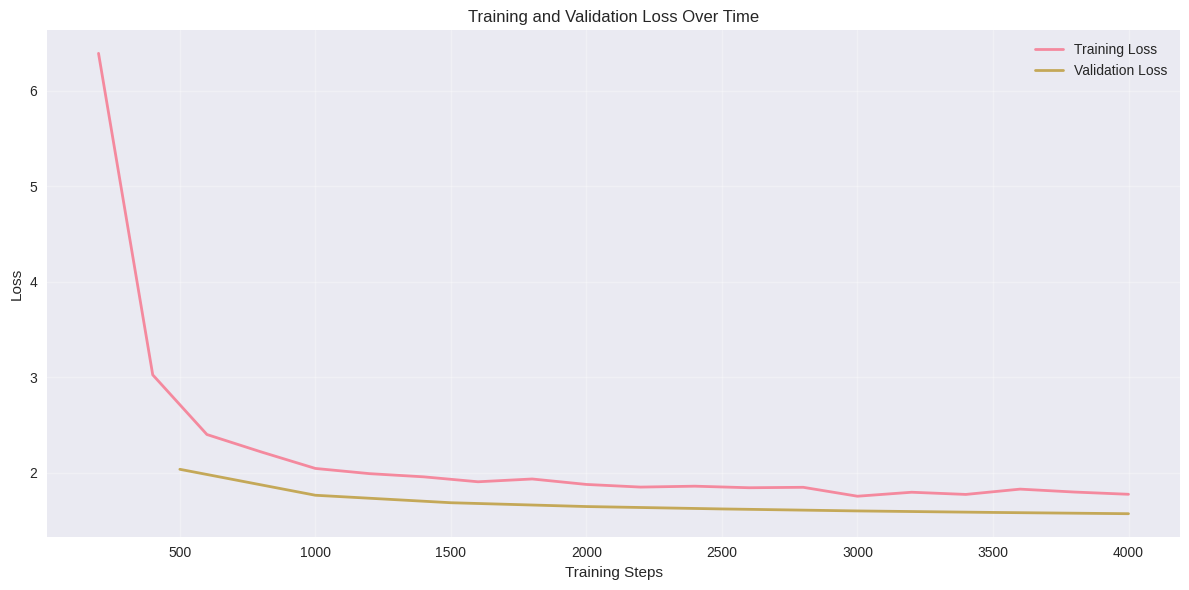

Final Training Loss: 1.7751
Final Validation Loss: 1.5717


In [47]:
# Cell: Plot training and validation loss
# Get training history from trainer
if hasattr(trainer, 'state') and trainer.state.log_history:
    # Extract training history
    train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
    steps = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
    
    # Create loss plot
    plt.figure(figsize=(12, 6))
    
    if train_loss:
        train_steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]
        plt.plot(train_steps, train_loss, label='Training Loss', linewidth=2, alpha=0.8)
    
    if eval_loss:
        plt.plot(steps, eval_loss, label='Validation Loss', linewidth=2, alpha=0.8)
    
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print final losses
    if train_loss:
        print(f"Final Training Loss: {train_loss[-1]:.4f}")
    if eval_loss:
        print(f"Final Validation Loss: {eval_loss[-1]:.4f}")
else:
    print("No training history found. Train the model first to see loss curves.")

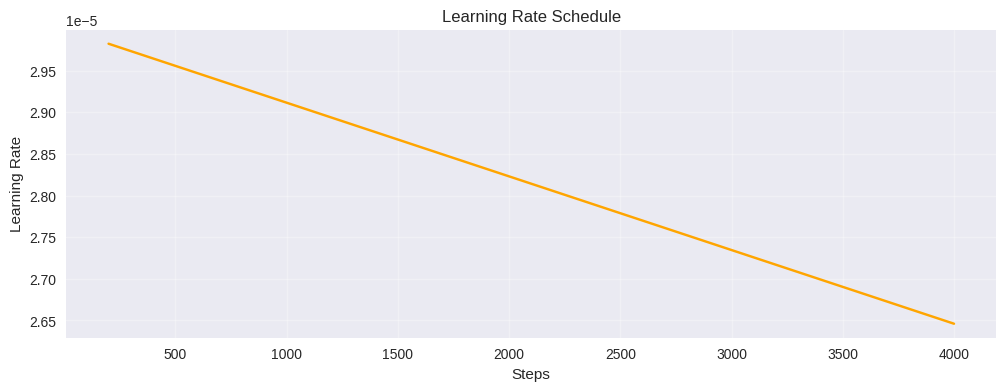

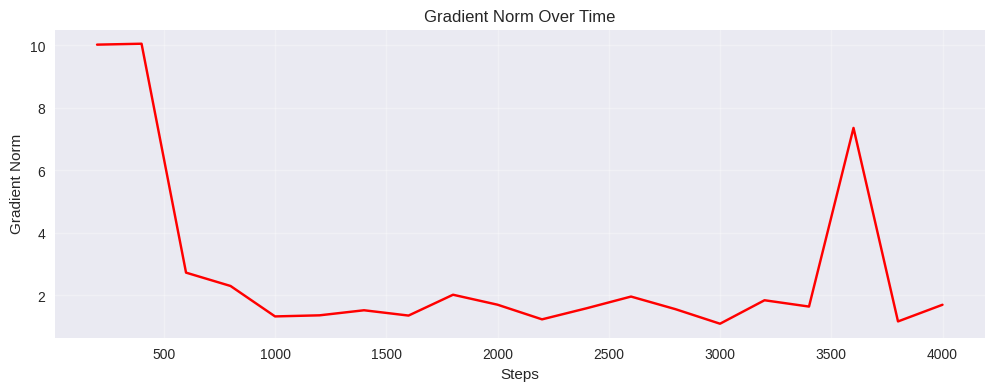

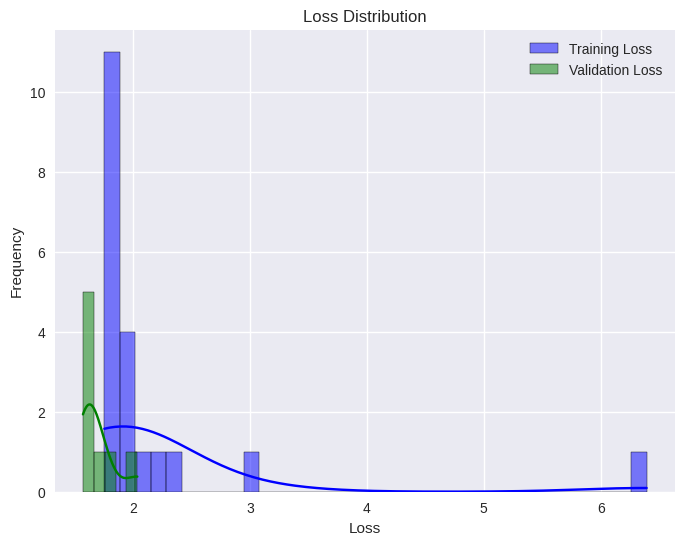

/tmp/ipykernel_292730/4092929360.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_loss, eval_loss], labels=['Train', 'Validation'])


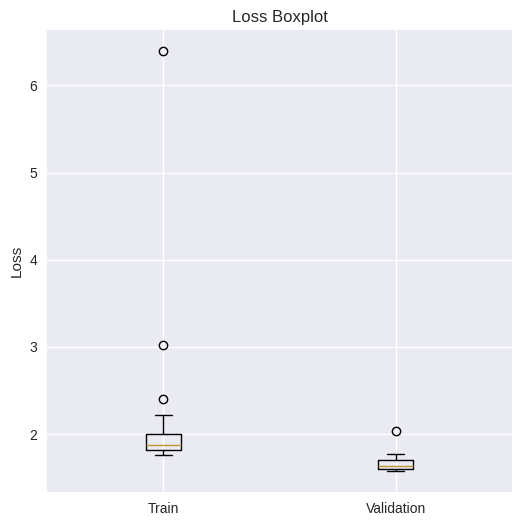

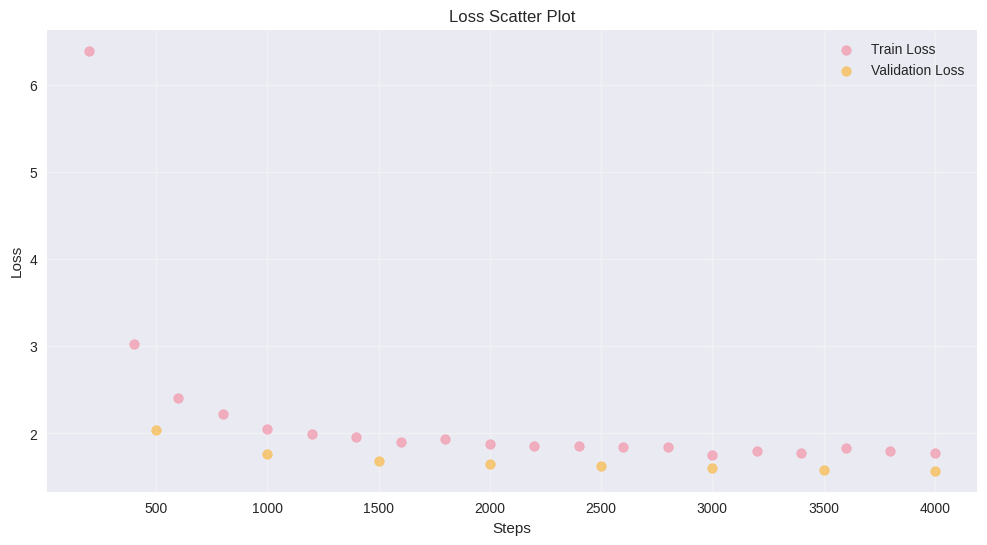

In [49]:
train_acc = [log['accuracy'] for log in trainer.state.log_history if 'accuracy' in log]
eval_acc = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]




lrs = [log['learning_rate'] for log in trainer.state.log_history if 'learning_rate' in log]
lr_steps = [log['step'] for log in trainer.state.log_history if 'learning_rate' in log]

plt.figure(figsize=(12, 4))
plt.plot(lr_steps, lrs, label='Learning Rate', color='orange')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)
plt.show()


grads = [log['grad_norm'] for log in trainer.state.log_history if 'grad_norm' in log]
grad_steps = [log['step'] for log in trainer.state.log_history if 'grad_norm' in log]

plt.figure(figsize=(12, 4))
plt.plot(grad_steps, grads, label='Gradient Norm', color='red')
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Over Time')
plt.grid(True, alpha=0.3)
plt.show()


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(train_loss, kde=True, color='blue', label='Training Loss')
sns.histplot(eval_loss, kde=True, color='green', label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.boxplot([train_loss, eval_loss], labels=['Train', 'Validation'])
plt.ylabel('Loss')
plt.title('Loss Boxplot')
plt.show()


plt.figure(figsize=(12, 6))
plt.scatter(train_steps, train_loss, alpha=0.5, label='Train Loss')
plt.scatter(steps, eval_loss, alpha=0.5, label='Validation Loss', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Training V3 with 20 epoch on pytorch and early stopping
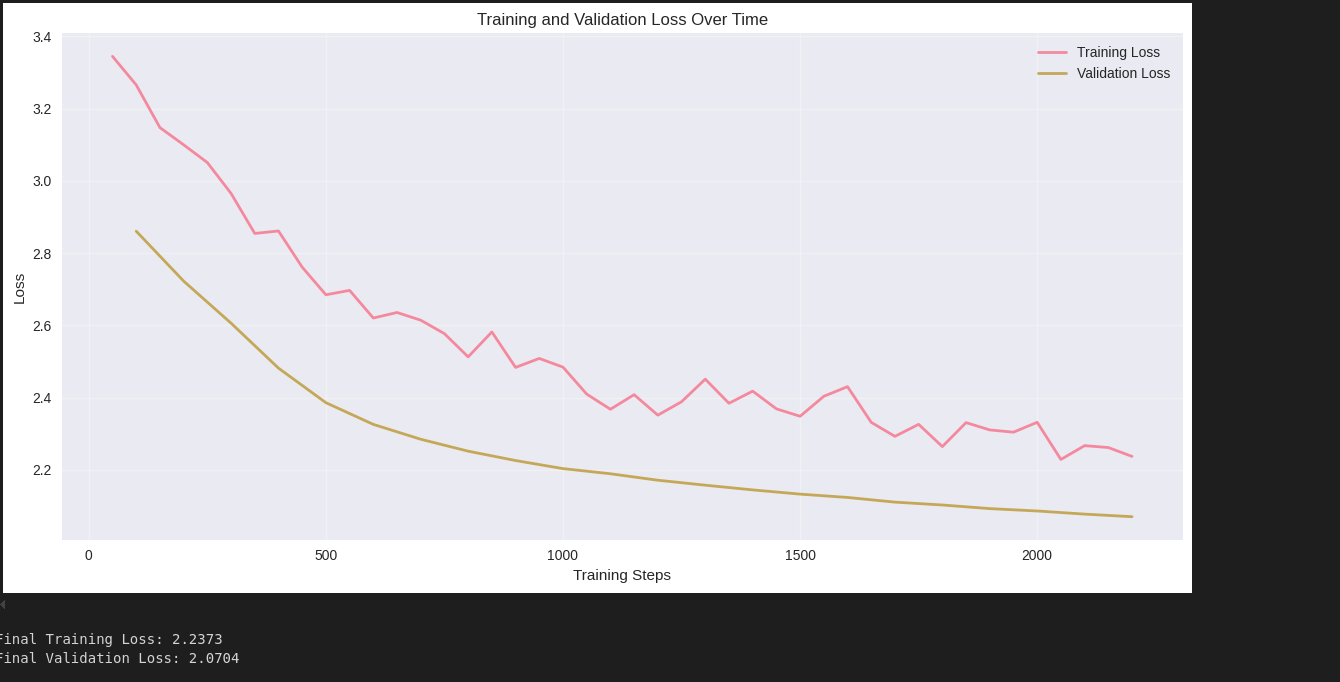

| Step | Training Loss | Validation Loss | Bleu     | Rouge1   | Rouge2   | Rougel  | Exact Match | Token F1  |
|------|----------------|-----------------|----------:|----------:|----------:|----------:|-------------:|----------:|
| 100  | 3.265600       | 2.860764        | 0.000238 | 0.116732 | 0.041293 | 0.102486 | 0.000000    | 0.094146 |
| 200  | 3.099900       | 2.722638        | 0.000694 | 0.131193 | 0.049334 | 0.114798 | 0.000000    | 0.107455 |
| 300  | 2.965300       | 2.606128        | 0.001600 | 0.136866 | 0.056378 | 0.120225 | 0.000000    | 0.114219 |
| 400  | 2.861300       | 2.481716        | 0.002737 | 0.140240 | 0.064490 | 0.123810 | 0.000000    | 0.116474 |
| 500  | 2.684700       | 2.386010        | 0.003056 | 0.149023 | 0.077542 | 0.131979 | 0.000000    | 0.127118 |
| 600  | 2.620400       | 2.325979        | 0.003479 | 0.152944 | 0.084037 | 0.137694 | 0.000000    | 0.132858 |
| 700  | 2.614400       | 2.284824        | 0.003595 | 0.153017 | 0.085752 | 0.138003 | 0.000000    | 0.133411 |
| 800  | 2.512800       | 2.251814        | 0.003521 | 0.153969 | 0.087712 | 0.139068 | 0.000000    | 0.134108 |
| 900  | 2.483700       | 2.225904        | 0.003714 | 0.157915 | 0.092225 | 0.142976 | 0.000629    | 0.137015 |
| 1000 | 2.484400       | 2.203551        | 0.003818 | 0.156863 | 0.090733 | 0.141817 | 0.000629    | 0.137259 |
| 1100 | 2.367800       | 2.189276        | 0.003969 | 0.158182 | 0.093823 | 0.143692 | 0.000629    | 0.138158 |
| 1200 | 2.351500       | 2.171396        | 0.003697 | 0.157980 | 0.094001 | 0.143600 | 0.000629    | 0.137576 |
| 1300 | 2.451200       | 2.157677        | 0.003639 | 0.160337 | 0.095827 | 0.145301 | 0.000629    | 0.139954 |
| 1400 | 2.418000       | 2.144619        | 0.003854 | 0.162005 | 0.097660 | 0.147354 | 0.000629    | 0.141580 |
| 1500 | 2.348400       | 2.132911        | 0.003771 | 0.160761 | 0.098101 | 0.147161 | 0.000629    | 0.141082 |
| 1600 | 2.430400       | 2.123723        | 0.003792 | 0.160683 | 0.099417 | 0.147791 | 0.000629    | 0.141454 |
| 1700 | 2.292800       | 2.110772        | 0.004044 | 0.160726 | 0.099072 | 0.147765 | 0.000629    | 0.141824 |
| 1800 | 2.264500       | 2.102847        | 0.004120 | 0.163657 | 0.100226 | 0.149112 | 0.000629    | 0.144548 |
| 1900 | 2.310600       | 2.092827        | 0.004554 | 0.164630 | 0.100893 | 0.150657 | 0.000629    | 0.145896 |
| 2000 | 2.331700       | 2.086260        | 0.004177 | 0.163519 | 0.099620 | 0.149113 | 0.000629    | 0.144975 |
| 2100 | 2.267100       | 2.077584        | 0.004128 | 0.166327 | 0.102862 | 0.152028 | 0.000629    | 0.147170 |
| 2200 | 2.237300       | 2.070417        | 0.004291 | 0.166752 | 0.103007 | 0.152710 | 0.000629    | 0.147817 |

### TRaining Metric Plloted
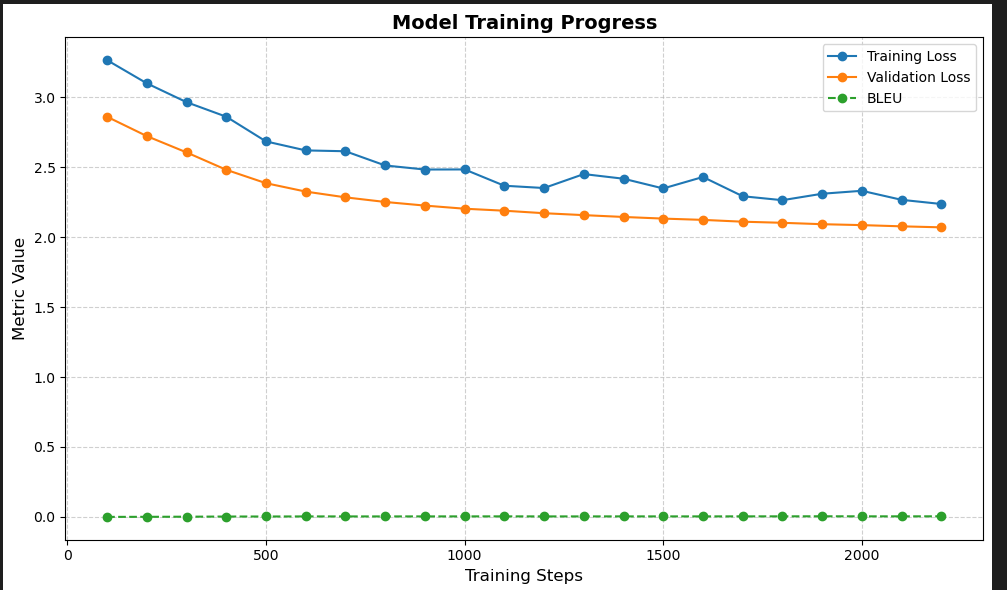


Step	Training Loss	Validation Loss	Bleu	Rouge1	Rouge2	Rougel	Exact Match	Token F1
300	0.000000	nan	0.000001	0.038001	0.007299	0.035294	0.000000	0.028596
600	0.000000	nan	0.000001	0.038001	0.007299	0.035294	0.000000	0.028596
900	0.000000	nan	0.000001	0.038001	0.007299	0.035294	0.000000	0.028596
1200	0.000000	nan	0.000001	0.038001	0.007299	0.035294	0.000000	0.028596
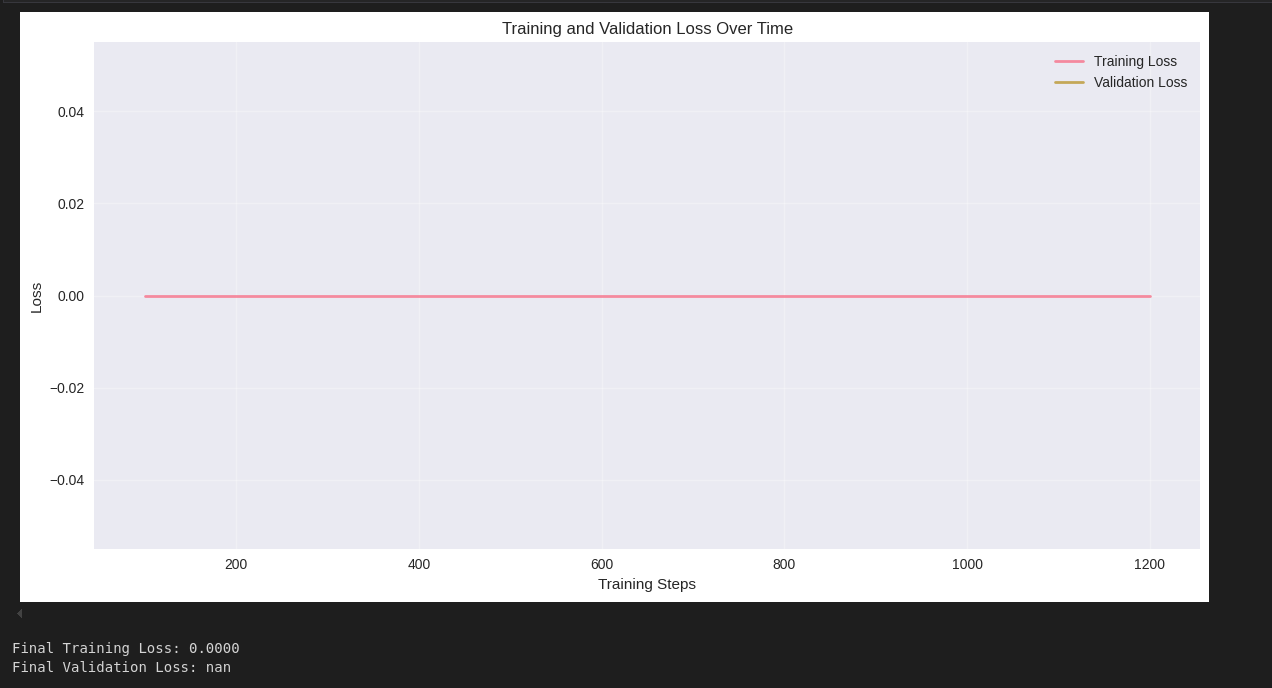
#### Paramas
```
training_args = Seq2SeqTrainingArguments(
    output_dir=str(OUT_DIR / f"{MODEL_NAME.split('/')[-1]}_health_tuned"),
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,                     # Smoother convergence for flan-t5-base
    num_train_epochs=30,                     # Prevent overfitting, stable generalization
    warmup_ratio=0.1,                       # Use ratio instead of fixed steps (10%)
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=300,                         # Less frequent but meaningful
    save_steps=600,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=True,
    seed=SEED,
    fp16=True,
    predict_with_generate=True,
    dataloader_pin_memory=True,
    gradient_accumulation_steps=24,          # Accumulate more for smoother gradients
    generation_max_length=256,              # Cap answer length
    generation_num_beams=24,                 # Beam search improves BLEU/ROUGE
    label_smoothing_factor=0.7,             # Prevents overconfidence, better F1
)

```

### V4 

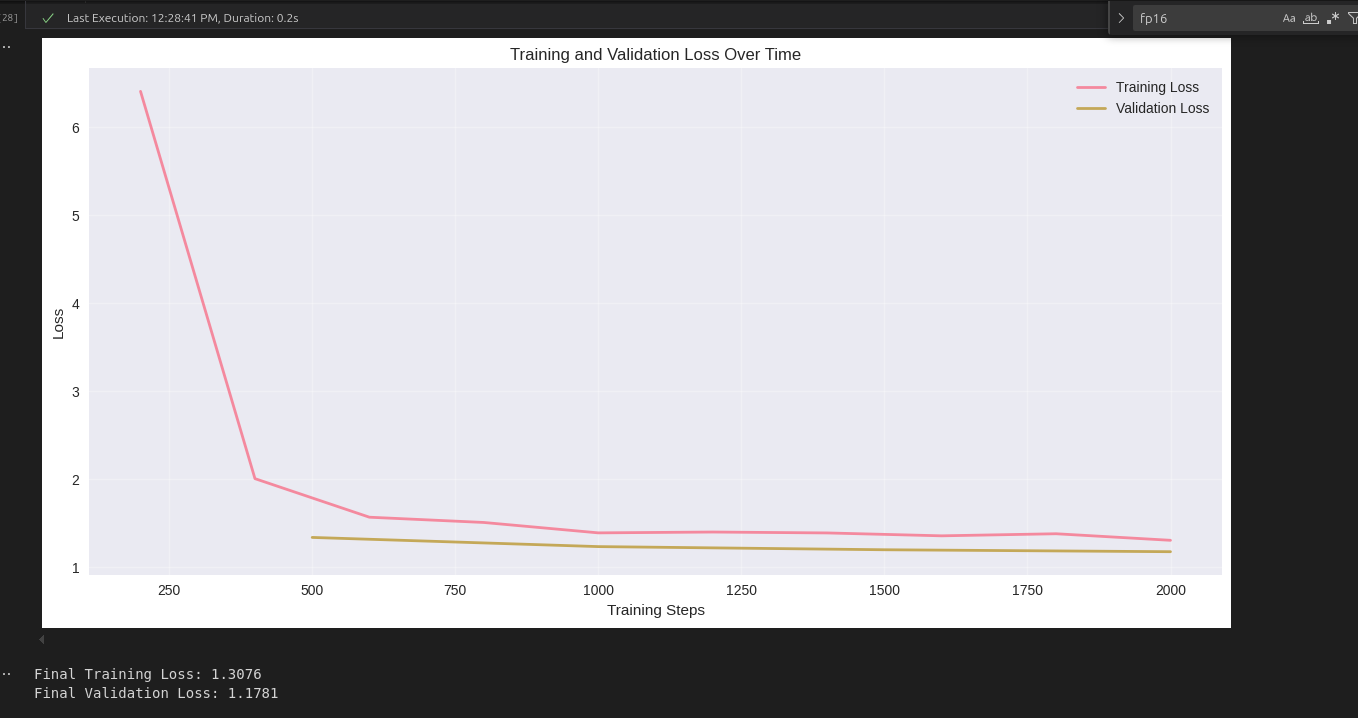

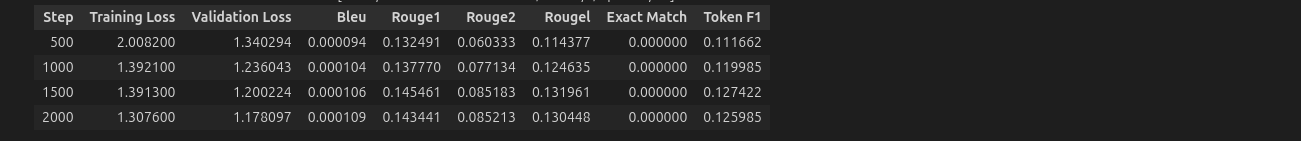

### v5

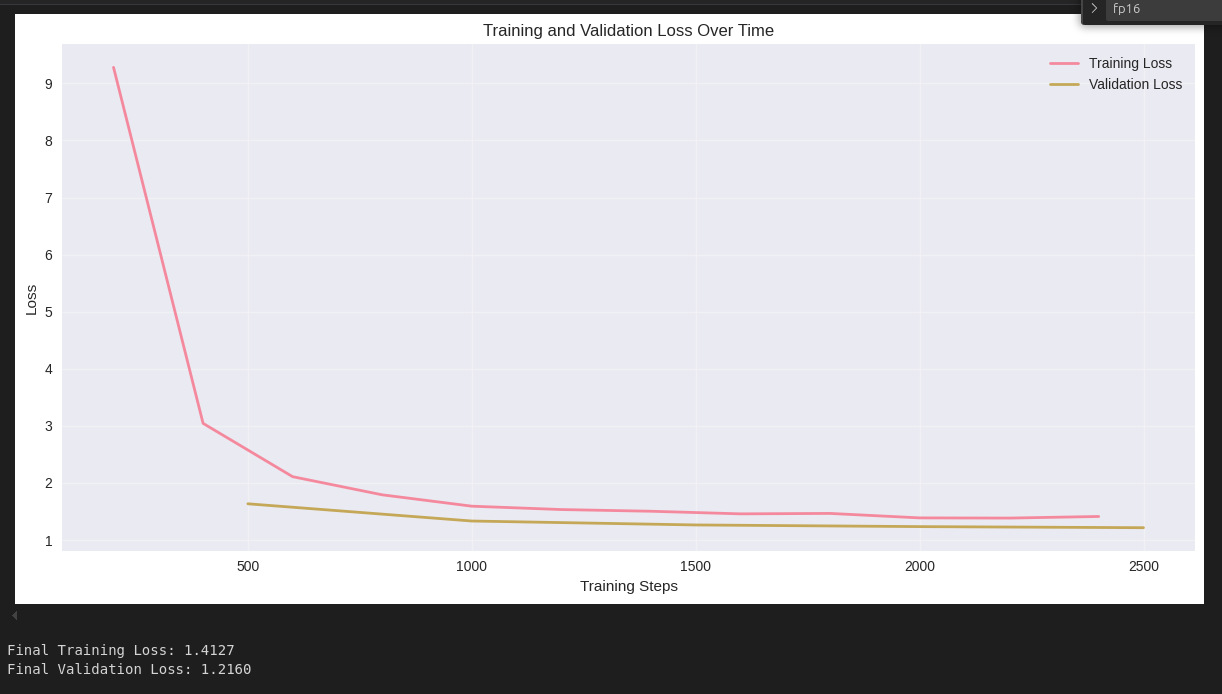

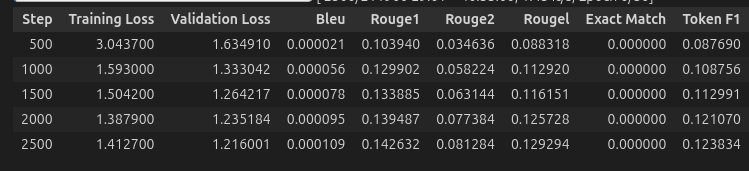

# Add early stopping callback
```
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.01
    )
```